In [1]:
#!pip install tensorflow==2.11.1
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
import psutil

import h5py
import gc
import qkeras
import tensorflow_model_optimization

2024-04-11 01:11:49.199430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 01:11:59.272584: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib:/usr/lib64:/usr/lib:/usr/lib64
2024-04-11 01:11:59.279840: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-11 01:12:39.942057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so

2.11.1
2.11.0


In [2]:
def print_memory_usage():
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage percentage: {memory.percent}%")

def print_cpu_usage():
    cpu_percent = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_percent}%")

In [3]:
def load_combine_shuffle_data_optimized_hdf5():
    with h5py.File('./fl32_data_v3.hdf5', 'r') as h5f:
        combined_input = None
        combined_target = None

        for data_type in ['sig', 'bkg']:
            # Construct dataset names
            input_dataset_name = f'{data_type}_input'
            target_dataset_name = f'{data_type}_target'

            # Check if the dataset exists and load data sequentially
            if input_dataset_name in h5f and target_dataset_name in h5f:
                input_data = h5f[input_dataset_name][:].astype(np.float32)
                target_data = h5f[target_dataset_name][:].astype(np.float32)

                if combined_input is None:
                    combined_input = input_data
                    combined_target = target_data
                    # Free memory of the loaded data
                    del input_data, target_data
                    gc.collect()

                else:
                    print_memory_usage()
                    combined_input = np.vstack((combined_input, input_data))
                    combined_target = np.vstack((combined_target, target_data))
                    # Free memory of the loaded data
                    del input_data, target_data
                    gc.collect()

            else:
                print(f"Dataset {input_dataset_name} or {target_dataset_name} not found.")

        # Shuffling
        indices = np.arange(combined_input.shape[0])
        np.random.shuffle(indices)
        combined_input = combined_input[indices]
        combined_target = combined_target[indices]

        return combined_input, combined_target

# Example usage
X, y = load_combine_shuffle_data_optimized_hdf5()

Total memory: 376.23 GB
Available memory: 150.02 GB
Used memory: 216.35 GB
Memory usage percentage: 60.1%


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def display(x_dataset, y_dataset, i):
    # Extract the i-th data point from both datasets
    x_data_point = x_dataset[i]
    y_data_point = y_dataset[i]

    # Check if the index is valid
    if x_data_point.shape != (20, 13, 21):
        raise ValueError("Invalid shape for the x data point")

    # Extracting the transverse momentum (pt) from the y dataset
    pt = y_data_point[8]  # Assuming the 9th variable is at index 8

    fig, ax_main = plt.subplots(figsize=(8, 6))
    divider = make_axes_locatable(ax_main)

    # Add row sum plot as an inset to the main plot
    ax_row = divider.append_axes("right", size="20%", pad=0.4)

    # Add column sum plot below the main plot
    ax_column = divider.append_axes("bottom", size="20%", pad=0.5)

    # Initial plot
    im = ax_main.imshow(x_data_point[0, :, :], cmap='plasma')
    ax_main.invert_yaxis()
    ax_main.set_yticks(np.arange(x_data_point.shape[1]))
    ax_main.set_xticks(np.arange(x_data_point.shape[2]))
    ax_main.set_xlim(0, x_data_point.shape[2]-1)
    ax_main.set_ylim(0, x_data_point.shape[1]-1)
    ax_main.grid(True, color='gray', alpha=0.7)

    # Function to update the animation
    def update(t):
        # Update main plot
        data = x_data_point[t, :, :]
        im.set_data(data)

        # Update row sum plot
        ax_row.clear()
        ax_row.barh(np.arange(data.shape[0]), np.sum(data, axis=1), color='red')
        ax_row.set_ylim(0, data.shape[0]-1)
        ax_row.set_yticks(np.arange(data.shape[0]))
        ax_row.set_xlim(np.min(x_data_point[:, :, :].sum(axis=2)) * 1.1, np.max(x_data_point[:, :, :].sum(axis=2)) * 1.1)
        ax_row.set_xlabel("Row Sum")

        # Update column sum plot
        ax_column.clear()
        ax_column.bar(np.arange(data.shape[1]), np.sum(data, axis=0), color='blue')
        ax_column.set_xlim(0, data.shape[1]-1)
        ax_column.set_xticks(np.arange(data.shape[1]))
        ax_column.set_ylim(np.min(x_data_point[:, :, :].sum(axis=1)) * 1.1, np.max(x_data_point[:, :, :].sum(axis=1)) * 1.1)
        ax_column.set_ylabel("Column Sum")

        # Update labels and grid
        ax_main.set_xlabel("X Position")
        ax_main.set_ylabel("Y Position")


        # Update title for the entire figure
        fig.suptitle(f"Timestep: {t+1} | Data Point: {i} | pt: {pt:.2f}")

    ani = FuncAnimation(fig, update, frames=8, repeat=True)
    plt.close()

    return HTML(ani.to_jshtml())

In [ ]:
n = X.shape[0]
X = X.reshape(n,20,13,21)
display(X, y, 19)

In [ ]:
def display_diff(x_dataset, y_dataset, i):
    # Extract the i-th data point from both datasets
    x_data_point = x_dataset[i]
    y_data_point = y_dataset[i]

    # Check if the index is valid
    if x_data_point.shape != (20, 13, 21):
        raise ValueError("Invalid shape for the x data point")

    # Extracting the transverse momentum (pt) from the y dataset
    pt = y_data_point[8]  # Assuming the 9th variable is at index 8

    fig, ax_main = plt.subplots(figsize=(8, 6))
    divider = make_axes_locatable(ax_main)

    # Add row sum plot as an inset to the main plot
    ax_row = divider.append_axes("right", size="20%", pad=0.4)

    # Add column sum plot below the main plot
    ax_column = divider.append_axes("bottom", size="20%", pad=0.5)

    # Initial plot
    im = ax_main.imshow(x_data_point[0, :, :], cmap='plasma')
    ax_main.invert_yaxis()
    ax_main.set_yticks(np.arange(x_data_point.shape[1]))
    ax_main.set_xticks(np.arange(x_data_point.shape[2]))
    ax_main.set_xlim(0, x_data_point.shape[2]-1)
    ax_main.set_ylim(0, x_data_point.shape[1]-1)
    ax_main.grid(True, color='gray', alpha=0.7)

    # Function to update the animation
    def update(t):
        # Calculate the difference between current and previous timestep
        if t == 0:
            data = x_data_point[t, :, :]
        else:
            data = x_data_point[t, :, :] - x_data_point[t-1, :, :]
        
        # Update main plot
        im.set_data(data)

        # Update row sum plot
        ax_row.clear()
        ax_row.barh(np.arange(data.shape[0]), np.sum(data, axis=1), color='red')
        ax_row.set_ylim(0, data.shape[0]-1)
        ax_row.set_yticks(np.arange(data.shape[0]))
        ax_row.set_xlim(np.min(data.sum(axis=1)) * 1.1, np.max(data.sum(axis=1)) * 1.1)
        ax_row.set_xlabel("Row Sum")

        # Update column sum plot
        ax_column.clear()
        ax_column.bar(np.arange(data.shape[1]), np.sum(data, axis=0), color='blue')
        ax_column.set_xlim(0, data.shape[1]-1)
        ax_column.set_xticks(np.arange(data.shape[1]))
        ax_column.set_ylim(np.min(data.sum(axis=0)) * 1.1, np.max(data.sum(axis=0)) * 1.1)
        ax_column.set_ylabel("Column Sum")

        # Update labels and grid
        ax_main.set_xlabel("X Position")
        ax_main.set_ylabel("Y Position")

        # Update title for the entire figure
        fig.suptitle(f"Timestep: {t+1} | Data Point: {i} | pt: {pt:.2f}")

    ani = FuncAnimation(fig, update, frames=20, repeat=True)
    plt.close()
    return HTML(ani.to_jshtml())

In [ ]:
display_diff(X, y, 1299)

In [ ]:
def check_zero_differences_all(x_dataset, start):
    # Get the number of data points in the dataset
    num_data_points = x_dataset.shape[0]
    all_zero_diff = True
    # Iterate over all data points
    for i in range(num_data_points):
        # Extract the i-th data point from the dataset
        x_data_point = x_dataset[i]

        # Check if the index is valid
        if x_data_point.shape != (20, 13, 21):
            raise ValueError(f"Invalid shape for data point {i}")

        print(f"Checking data point {i}:")

        # Flag to track if all differences are zero
        
        # Iterate over time steps starting from the 9th time frame
        for t in range(start, 20):
            # Calculate the difference between current and previous timestep
            diff = x_data_point[t, :, :] - x_data_point[t-1, :, :]

            # Check if all differences are zero
            if not np.allclose(diff, 0):
                all_zero_diff = False
                print(f"  Timestep {t+1}: Non-zero differences exist.")
                break

    if all_zero_diff:
        print(f"  All differences are zero for timesteps {start} to 20.")

    print()  # Print an empty line for separation
check_zero_differences_all(X, 13)

In [4]:
X = X.reshape(-1, 20*13*21)
n = X.shape[0]
X = X.reshape(n,20,13,21)
X= X[:, :8, :, :]
print_memory_usage()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
del X
del y
gc.collect()
print_memory_usage()
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
del X_temp
del y_temp
gc.collect()
print_memory_usage()

Total memory: 376.23 GB
Available memory: 150.01 GB
Used memory: 216.37 GB
Memory usage percentage: 60.1%
Total memory: 376.23 GB
Available memory: 156.73 GB
Used memory: 209.66 GB
Memory usage percentage: 58.3%
Total memory: 376.23 GB
Available memory: 156.72 GB
Used memory: 209.66 GB
Memory usage percentage: 58.3%


In [5]:
def to_sum(X, y):
    if X.shape[1:] == (8, 13, 21) and y.shape[1:] == (13, ):
        #y_expanded = np.repeat(y[:,7], 8, axis=0).reshape(-1, 8, 1)
        X_sum = np.sum(X, axis=3)
        X_sum.reshape(X_sum.shape[0],8,13,1)
        n = y.shape[0]
        # one_hot = np.zeros((n, 3))
        one_hot = np.zeros((n, 1))

        # Class 1: np.abs(y[:, 8]) > 2
        one_hot[np.abs(y[:, 8]) >= 2, 0] = 1
        # one_hot[np.abs(y[:, 8]) < 2, 1] = 1

        # # Class 2: np.abs(y[:, 8]) <= 2 and y[:, 13] == 1
        # one_hot[(np.abs(y[:, 8]) < 2) & (y[:, 8] > 0), 1] = 1

        # # Class 3: np.abs(y[:, 8]) <= 2 and y[:, 13] == -1
        # one_hot[(np.abs(y[:, 8]) < 2) & (y[:, 8] < 0), 2] = 1
        return X_sum, one_hot, y[:,7].reshape(-1, 1)
    else:
        raise ValueError("Wrong array shape!")

X_sum_train, y_sum_train, y0_train = to_sum(X_train, y_train)
X_sum_val, y_sum_val, y0_val = to_sum(X_val, y_val)
X_sum_test, y_sum_test, y0_test = to_sum(X_test, y_test)
del X_train
del y_train
del X_val
del y_val
del X_test
del y_test
gc.collect()
print_memory_usage()

Total memory: 376.23 GB
Available memory: 160.98 GB
Used memory: 205.40 GB
Memory usage percentage: 57.2%


In [8]:
print(X_sum_test.shape)
print(y_sum_test.shape)
print(y0_test.shape)

(54843, 8, 13)
(54843, 1)
(54843, 1)


In [12]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

qmodel_pruned = load_model('/fs/ddn/sdf/group/atlas/d/hjia625/Smart_Pixel/CNN_maybebest_quantized_pruned.h5', custom_objects=co)

2024-04-11 01:19:50.452235: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib:/usr/lib64:/usr/lib:/usr/lib64
2024-04-11 01:19:50.490189: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-11 01:19:50.516702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sdfiana008): /proc/driver/nvidia/version does not exist
2024-04-11 01:19:50.639228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
X_sum_test_flattened = X_sum_test.reshape(54843, -1)

# Concatenate X_sum_test_flattened with y0_test along axis 1 to get a (54843, 105) shape
input_features = np.hstack((X_sum_test_flattened, y0_test))

# Write to file
with open('tb_input_features.dat', 'w') as file:
    for row in input_features:
        line = ' '.join(map(str, row))  # Convert each number to string and join with space
        file.write(line + '\n')

In [10]:
with open('./tb_output_predictions.dat', 'w') as file:
    for score in y_sum_test:
        file.write(str(score[0]) + '\n')  # Convert number to string

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, ReLU, Dropout, BatchNormalization, Activation
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
def qCNNmodel():
    y_profile_input = Input(shape=(8, 13, 1), name='y_profile_input')  # Adjust the shape based on your input

    # Convolutional layers with BatchNorm and Activation
    conv1 = QConv2DBatchnorm(
        3,
        kernel_size=(3, 3),
        padding='same',
        strides=(1, 1),
        kernel_quantizer="quantized_bits(24,8,alpha=1)",
        bias_quantizer="quantized_bits(24,8,alpha=1)",
        scale=True,
        center=True,
        name='conv1'
    )(y_profile_input)
    act1 = QActivation('quantized_relu(24,8)')(conv1)
    maxpool1 = MaxPooling2D(pool_size=(2, 2), name='maxpool1')(act1)

    conv2 = QConv2DBatchnorm(
        4,
        kernel_size=(3, 3),
        padding='same',
        strides=(1, 1),
        kernel_quantizer="quantized_bits(24,8,alpha=1)",
        bias_quantizer="quantized_bits(24,8,alpha=1)",
        scale=True,
        center=True,
        name='conv2'
    )(maxpool1)
    act2 = QActivation('quantized_relu(24,8)')(conv2)
    maxpool2 = MaxPooling2D(pool_size=(2, 2), name='maxpool2')(act2)

    # Flatten the output to feed into a dense layer
    flattened = Flatten(name='flattened')(maxpool2)

    # Flatten and concatenate with y0 input
    y0_input = Input(shape=(1,), name='y0_input')
    concat = Concatenate(name='concat')([flattened, y0_input])

    # Dense layer
    dense1 = QDense(4, kernel_quantizer="quantized_bits(24,8,alpha=1)", bias_quantizer="quantized_bits(24,8,alpha=1)", name='dense1')(concat)
    act3 = QActivation('quantized_relu(24,8)')(dense1)
    dropout = Dropout(0.05, name='dropout')(act3)

    # Output layer (adjust based on your classification problem)
    # output = Dense(3, activation='softmax', name='output_softmax')(dropout)  # Change number of neurons based on the number of classes
    dense2 = QDense(1, kernel_quantizer="quantized_bits(24,8,alpha=1)", bias_quantizer="quantized_bits(24,8,alpha=1)", name='dense2')(dropout)
    output = Activation("sigmoid", name='output_sigmoid')(dense2)
    # Create the model
    model = Model(inputs=[y_profile_input, y0_input], outputs=output)

    # Compile the model
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model
# Example usage
model = qCNNmodel()
model.summary()

2024-04-07 22:25:19.823212: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib:/usr/lib64:/usr/lib:/usr/lib64
2024-04-07 22:25:19.873014: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-07 22:25:19.887920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sdfiana008): /proc/driver/nvidia/version does not exist
2024-04-07 22:25:20.019989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 y_profile_input (InputLayer)   [(None, 8, 13, 1)]   0           []                               
                                                                                                  
 conv1 (QConv2DBatchnorm)       (None, 8, 13, 3)     43          ['y_profile_input[0][0]']        
                                                                                                  
 q_activation (QActivation)     (None, 8, 13, 3)     0           ['conv1[0][0]']                  
                                                                                           

In [7]:
earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                   mode='min',
                                   patience=20,
                                   restore_best_weights=True)

In [8]:
epochs = 100  # Number of epochs to train
batch_size = 1024  # Number of samples per gradient update

# Train the model
history = model.fit(
    [X_sum_train, y0_train], y_sum_train,  # Training data and labels
    validation_data=([X_sum_val, y0_val], y_sum_val),  # Validation data
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[earlyStop_callback]
)

Epoch 1/100
429/429 [==============================] - 21s 34ms/step - loss: 0.7695 - accuracy: 0.5007 - val_loss: 0.6962 - val_accuracy: 0.5005
Epoch 2/100
429/429 [==============================] - 15s 34ms/step - loss: 0.6948 - accuracy: 0.4990 - val_loss: 0.6936 - val_accuracy: 0.5045
Epoch 3/100
429/429 [==============================] - 18s 42ms/step - loss: 0.6934 - accuracy: 0.5014 - val_loss: 0.6933 - val_accuracy: 0.5050
Epoch 4/100
429/429 [==============================] - 20s 46ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 5/100
429/429 [==============================] - 20s 45ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5007
Epoch 6/100
429/429 [==============================] - 14s 33ms/step - loss: 0.6931 - accuracy: 0.5030 - val_loss: 0.6931 - val_accuracy: 0.4999
Epoch 7/100
429/429 [==============================] - 19s 44ms/step - loss: 0.6930 - accuracy: 0.5023 - val_loss: 0.6930 - val_ac

In [ ]:
model.save('/fs/ddn/sdf/group/atlas/d/hjia625/Smart_Pixel/CNN_best_quantized.h5')

In [ ]:
from qkeras.autoqkeras.utils import print_qmodel_summary

print_qmodel_summary(model)

In [18]:
import tensorflow
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(X_sum_train.shape[0] * 0.9) // 1024  # 90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))

# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params1 = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=0.25,
            begin_step=NSTEPS * 2,
            end_step=NSTEPS * 7,
            frequency=NSTEPS
        )
    }

    pruning_params2 = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=0.25,
            begin_step=NSTEPS * 2,
            end_step=NSTEPS * 7,
            frequency=NSTEPS
        )
    }

    # if isinstance(layer, QConv2DBatchnorm):
    #     print(f"find layer {layer.name} prunable")
    #     return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)

    if isinstance(layer, QDense):
        if layer.name != 'output_softmax' and layer.name != 'dense2':
            print(f"find layer {layer.name} prunable")
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params1)
        elif layer.name != 'output_softmax' and layer.name != 'dense1':
            print(f"find layer {layer.name} prunable")
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params2)
        else:
            print(f"find layer {layer.name} not prunable")
            return layer

    else:
        print(f"find layer {layer.name} not prunable")
        return layer
qmodel_pruned = 0
qmodel_pruned = keras.models.clone_model(model, clone_function=pruneFunction)
qmodel_pruned.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Number of training steps per epoch is 385
find layer conv1 not prunable
find layer q_activation not prunable
find layer maxpool1 not prunable
find layer conv2 not prunable
find layer q_activation_1 not prunable
find layer maxpool2 not prunable
find layer flattened not prunable
find layer concat not prunable
find layer dense1 prunable
find layer q_activation_2 not prunable
find layer dropout not prunable
find layer dense2 prunable
find layer output_sigmoid not prunable


In [19]:
epochs = 7  # Number of epochs to train
batch_size = 1024  # Number of samples per gradient update

# Train the model
history = qmodel_pruned.fit(
    [X_sum_train, y0_train], y_sum_train,  # Training data and labels
    validation_data=([X_sum_val, y0_val], y_sum_val),  # Validation data
    epochs=epochs,
    batch_size=batch_size,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=7, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]
)

Epoch 1/7
429/429 [==============================] - 17s 32ms/step - loss: 0.6914 - accuracy: 0.5137 - val_loss: 0.6888 - val_accuracy: 0.5449
Epoch 2/7
429/429 [==============================] - 13s 30ms/step - loss: 0.6863 - accuracy: 0.5377 - val_loss: 0.6851 - val_accuracy: 0.5509
Epoch 3/7
429/429 [==============================] - 13s 31ms/step - loss: 0.6844 - accuracy: 0.5411 - val_loss: 0.6833 - val_accuracy: 0.5508
Epoch 4/7
429/429 [==============================] - 13s 30ms/step - loss: 0.6839 - accuracy: 0.5375 - val_loss: 0.6835 - val_accuracy: 0.5377
Epoch 5/7
429/429 [==============================] - 13s 30ms/step - loss: 0.6840 - accuracy: 0.5351 - val_loss: 0.6832 - val_accuracy: 0.5404
Epoch 6/7
429/429 [==============================] - 13s 31ms/step - loss: 0.6836 - accuracy: 0.5365 - val_loss: 0.6827 - val_accuracy: 0.5452
Epoch 7/7
429/429 [==============================] - 13s 31ms/step - loss: 0.6834 - accuracy: 0.5374 - val_loss: 0.6821 - val_accuracy: 0.5444

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

1714/1714 [==============================] - 9s 3ms/step


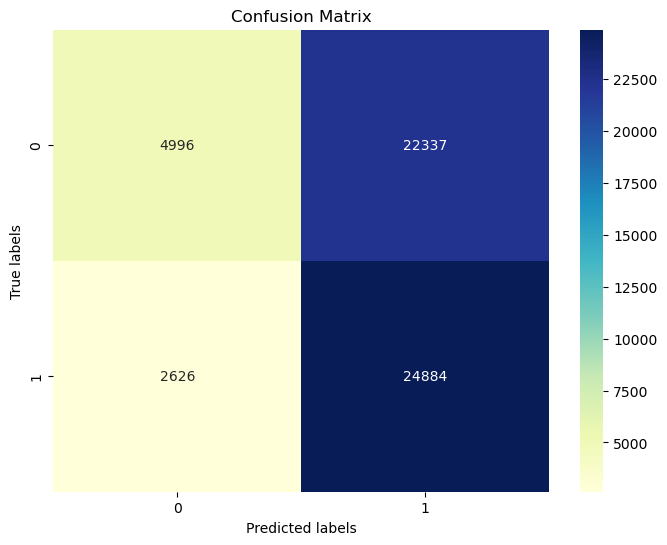

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions_prob = qmodel_pruned.predict([X_sum_test, y0_test])
predictions_labels = (predictions_prob >= 0.5).astype(int).flatten()
y_test_labels = y_sum_test

cm = confusion_matrix(y_test_labels, predictions_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
#print(predictions_prob[0:30])
print(y_sum_test[0:30])

[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


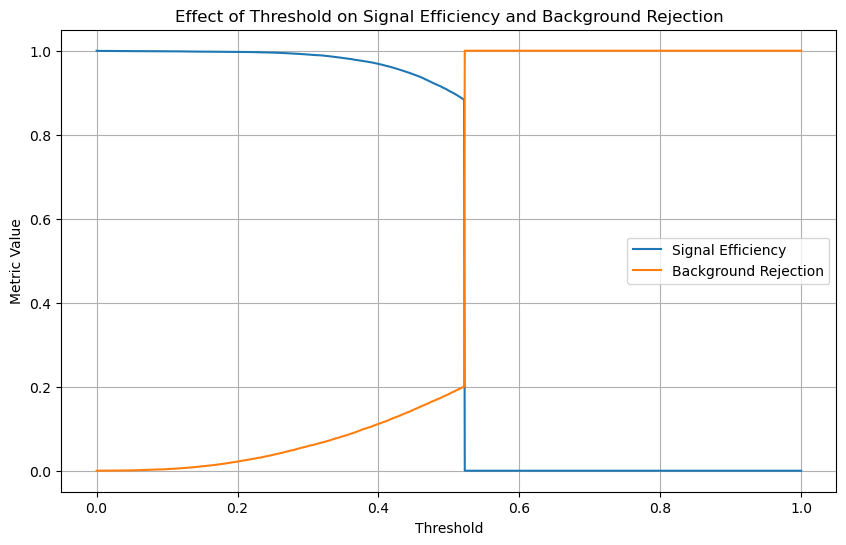

In [19]:
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0.0, 1.0, 1000)
signal_efficiencies = []
background_rejections = []

for threshold in thresholds:
    # predicted_class = ((predictions_prob[:, 0] + threshold > predictions_prob[:, 1]) & (predictions_prob[:, 0] + threshold > predictions_prob[:, 2])).astype(int)
    predicted_class = (predictions_prob > threshold).astype(int)
    # Compute confusion matrix
    cm = confusion_matrix(y_sum_test[:, 0], predicted_class)

    # Calculate signal efficiency and background rejection
    signal_efficiency = cm[1, 1] / np.sum(cm[1, :])
    background_rejection = cm[0, 0] / np.sum(cm[0, :])

    # Store metrics
    signal_efficiencies.append(signal_efficiency)
    background_rejections.append(background_rejection)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, signal_efficiencies, label='Signal Efficiency')
plt.plot(thresholds, background_rejections, label='Background Rejection')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Effect of Threshold on Signal Efficiency and Background Rejection')
plt.legend()
plt.grid(True)
plt.show()

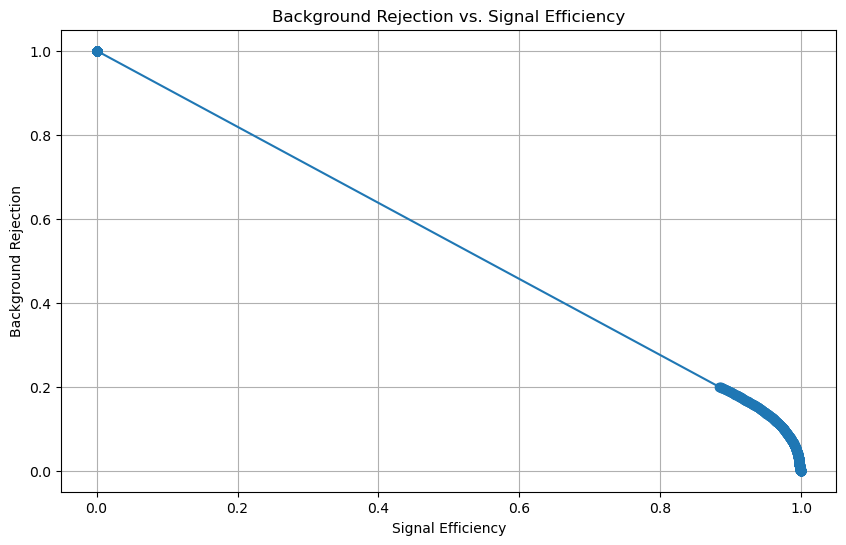

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(signal_efficiencies, background_rejections, marker='o')
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Background Rejection vs. Signal Efficiency')
plt.grid(True)
plt.show()

In [28]:
def find_closest(sorted_array, value):
    # Ensure the array is a NumPy array
    sorted_array = np.array(sorted_array)

    # Compute the absolute difference
    abs_diff = np.abs(sorted_array - value)

    # Find the index of the minimum difference
    closest_index = np.argmin(abs_diff)

    return closest_index


index_848 = find_closest(signal_efficiencies, 0.848)
index_933 = find_closest(signal_efficiencies, 0.933)
index_976 = find_closest(signal_efficiencies, 0.976)
index_995 = find_closest(signal_efficiencies, 0.995)
index_997 = find_closest(signal_efficiencies, 0.997)
print(f"Signal Efficiency:{signal_efficiencies[index_848]*100:.1f}%",f"Background Rejections:{background_rejections[index_848]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_933]*100:.1f}%",f"Background Rejections:{background_rejections[index_933]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_976]*100:.1f}%",f"Background Rejections:{background_rejections[index_976]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_995]*100:.1f}%",f"Background Rejections:{background_rejections[index_995]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_997]*100:.1f}%",f"Background Rejections:{background_rejections[index_997]*100:.1f}%")

Signal Efficiency:88.0% Background Rejections:19.7%
Signal Efficiency:93.3% Background Rejections:15.3%
Signal Efficiency:97.6% Background Rejections:9.4%
Signal Efficiency:99.5% Background Rejections:3.5%
Signal Efficiency:99.7% Background Rejections:1.5%


In [ ]:
print(np.sum(y_sum_train[:,0]))
print(y_sum_train.shape)

In [26]:
qmodel_pruned.save('/fs/ddn/sdf/group/atlas/d/hjia625/Smart_Pixel/CNN_maybebest_quantized_pruned.h5')